### Barcode Demultiplexer Simulator 

- Simulate Demultiplexing using local and semi-global alignment

In [21]:
import sys
sys.path.append("/home/emre/github_repo/MinION")
from minION import analyser
from minION import consensus
from minION import demultiplexer
import importlib
from minION.util import IO_processor
from minION.util.globals import BARCODES, MEDAKA_MODELS, DEFAULT_TARGETS
importlib.reload(IO_processor)
importlib.reload(analyser)
importlib.reload(consensus)
importlib.reload(demultiplexer)
from pathlib import Path
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
#import plotly.express as px
import random
from Bio import SeqIO
import subprocess

In [ ]:
# Plotly version
def barcode_score(summary):
    fig = px.histogram(summary, x="barcode_score", nbins=100, 
                       title="Barcode Score Distribution", labels={'barcode_score': 'Barcode Score', 'count': 'Frequency'})
    fig.update_traces(marker_color='red', marker_line_color='black', marker_line_width=1.5, opacity=0.5)
    fig.update_layout(width=600, height=400)
    return fig

def barcode_barplot(summary, barcode_id="barcode_arrangement", ylim=None):
    barcodes = summary[barcode_id].value_counts().reset_index()
    fig = px.bar(barcodes, x=barcode_id, y="count", 
                 title="Barcode Frequency", labels={'index': 'Barcode ID', barcode_id: 'Frequency'})
    fig.update_traces(marker_color='red', marker_line_color='black', marker_line_width=1.5, opacity=0.5)
    fig.update_layout(width=600, height=400)

    if ylim:
        fig.update_layout(yaxis=dict(range=[0, ylim]))

    return fig

def barcode_arrangement(summary, plot=True):
    barcode_arrangements = summary["barcode_arrangement"].value_counts().reset_index()

    if plot:
        fig = px.bar(barcode_arrangements, x='barcode_score', y='barcode_arrangement', 
                     title="Barcode Frequency", labels={'index': 'Barcode ID', 'barcode_arrangement': 'Frequency'})
        fig.update_traces(marker_color='red', marker_line_color='black', marker_line_width=1.5, opacity=0.5)
        fig.update_layout(width=600, height=400)
        return fig
    else:
        return barcode_arrangements

In [11]:

def check_gc_content(sequence, desired_gc_fraction, tolerance=0.05):
    """
    Check if the GC content of the sequence is within the desired range.
    """
    gc_count = sum(1 for nucleotide in sequence if nucleotide in ['G', 'C'])
    gc_fraction = gc_count / len(sequence)
    return abs(gc_fraction - desired_gc_fraction) <= tolerance

def generate_gc_content_sequence(length, desired_gc_fraction):
    """
    Iteratively generate a random DNA sequence until it has the desired GC content.
    """
    while True:
        sequence = ''.join(random.choice('ATCG') for _ in range(length))
        if check_gc_content(sequence, desired_gc_fraction):
            return sequence


def introduce_mutations(sequence, mutation_rate, weights = [0.2, 0.4, 0.4]):
    """
    Introduce mutations in a sequence with the specified mutation rate.
    The mutations include substitution, insertion, and deletion.
    """
    mutated_sequence = ''
    nucleotides = ['A', 'C', 'G', 'T']
    
    weights = {'substitution': weights[0], 'insertion': weights[1], 'deletion': weights[2]}

    i = 0
    while i < len(sequence):
        if random.random() < mutation_rate:
            mutation_type = random.choices(['substitution', 'insertion', 'deletion'], weights=[weights['substitution'], weights['insertion'], weights['deletion']])[0]
            if mutation_type == 'substitution':
                mutated_sequence += random.choice([n for n in nucleotides if n != sequence[i]])
                i += 1
            elif mutation_type == 'insertion':
                mutated_sequence += random.choice(nucleotides)
            else:  # deletion
                i += 1
                continue
        else:
            mutated_sequence += sequence[i]
            i += 1
    return mutated_sequence

### Generate the synthetic sequences

- GC content of 60 %


In [ ]:

def write_to_fastq(filename, barcodes, sequence_length, barcode_position_start, barcode_position_end, mutation_rate, num_sequences, num_noise):
    """
    Write mutated sequences for each barcode into a FASTQ file using a fixed surrounding sequence.
    """
    with open(filename, 'wt') as fastq_file:
        for i in range(num_sequences):
            # Generate one surrounding sequence for the set of barcodes
            surrounding_sequence = generate_gc_content_sequence(sequence_length, 0.6)

            for barcode_name, barcode_sequence in barcodes.items():
                # Introduce mutations in the barcode sequence
                mutated_barcode_sequence = introduce_mutations(barcode_sequence, mutation_rate)

                # Insert the mutated barcode sequence in the surrounding sequence
                mutated_sequence = surrounding_sequence[:barcode_position_start] + mutated_barcode_sequence + surrounding_sequence[barcode_position_end:]
                
                # Assign quality scores
                quality_scores = "I" * len(mutated_sequence)
                
                mut_r = str(mutation_rate).replace(".", "_")
                # Write to FASTQ file
                fastq_file.write(f"@seq_{mut_r}_{i + 1}_{barcode_name}\n")
                fastq_file.write(f"{mutated_sequence}\n")
                fastq_file.write("+\n")
                fastq_file.write(f"{quality_scores}\n")


        for i in range(num_noise):
        # Generate random noise sequence
            noise_sequence = generate_gc_content_sequence(sequence_length, 0.6)
            
            # Assign quality scores
            quality_scores = "I" * sequence_length
            
            # Write to FASTQ file
            fastq_file.write(f"@noise_{i + 1}\n")
            fastq_file.write(f"{noise_sequence}\n")
            fastq_file.write("+\n")
            fastq_file.write(f"{quality_scores}\n")

def split_read_id(read_id):
    """
    Split the read ID into the barcode ID and the read ID.
    """
    parts = read_id.split("_")
    barcode_id = parts[-1]
    read_id_prefix = "_".join(parts[:-1])

    if barcode_id.isnumeric():
        barcode_id = "noise"
    return barcode_id



In [ ]:
from Bio import SeqIO
barcodes = {}
with open("/home/emre/github_repo/MinION/minION/barcoding/minion_barcodes_sim.fasta", "r") as handle:
    records = list(SeqIO.parse(handle, "fasta"))
    for record in records:
        barcodes[record.id] = str(record.seq) 

In [ ]:


names = ["0", "01", "02", "03", "04"]
for i, rate in enumerate([0, 0.1, 0.2, 0.3, 0.4]):
    sequence_length = 150
    barcode_position_start = 70
    barcode_position_end = 94
    mutation_rate = rate # 10% mutation rate
    num_sequences = 9000
    num_noise = 0

    # Write sequences to a FASTQ file
    write_to_fastq(f"data/mutated_sequences_{names[i]}_8barcodes.fastq", barcodes, sequence_length, barcode_position_start, barcode_position_end, mutation_rate, num_sequences, num_noise)


In [ ]:
#file_names = ["00_0", "00_1", "00_2", "01_0", "01_1", "01_2", "02_0", "02_1", "02_2"]
file_names = ["tpr_fpr_testing"]

for file in file_names:
    path = Path("data") / file / "8_barcodes" 
    demultiplexer.run_demultiplexer_single(path, BARCODES, 15, 15, basecall_folder = path)

    # Calculate TP, FP, FN, TN
    #summary = pd.read_csv(Path("data") / file / "24_barcodes" / "demultiplex_15" / "barcoding_summary.csv")
    #summary["Truth"] = summary["read_id"].apply(split_read_id)
    

### CPP Analyser

In [ ]:
### Summary for CPP 

summary = pd.read_csv("/home/emre/github_repo/MinION/examples/data/Demultiplex_cpp/barcoding_summary.txt", sep="\t")
#summary = pd.read_csv("/home/emre/github_repo/MinION/examples/data/tpr_fpr_testing/24_barcodes/demultiplex_15/barcoding_summary.txt", sep="\t")
summary["Truth"] = summary["ID"].apply(split_read_id)
bins = np.arange(15, 105, 5)
summary["bins"] = pd.cut(summary["RBC_Score"], bins)

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Create the histogram plot
sns.histplot(data=summary, x="RBC_Score", bins=100, kde=False, ax=ax, color="navy", alpha=0.5)


# Add custom legend with the correct colors
custom_lines = [plt.Line2D([0], [0], color="navy", lw=4)]

#ax.legend(custom_lines, [''])
# Add labels and title
ax.set_xlabel("Barcode Score")
ax.set_ylabel("Frequency")
#ax.set_title("Barcode Score Distribution")

# Add a red vertical line
#ax.axvline(x=60, color='red', linestyle='--')

# Show the plot
plt.savefig("barcode_score_distribution_guppy_quality_test_8barcodes_CPP.png", dpi=300)
plt.show()

In [ ]:
TPR_interval = {"Interval" : [], "TPR" : [], "FPR" : []}
barcode_column = "RBC"
for intervals in summary["bins"].unique().sort_values():
    bin_df = summary[summary["bins"] == intervals]
    
    tpr = []
    fpr = []

    fp = bin_df[(bin_df[barcode_column] != bin_df["Truth"])]
    tp = bin_df[(bin_df[barcode_column] == bin_df["Truth"])]

    print(f"TPR for {intervals}: {len(tp) / (len(bin_df) +1)}")
    print(f"FPR for {intervals}: {len(fp) / (len(bin_df)+1)}")

    TPR_interval["Interval"].append(intervals)
    TPR_interval["TPR"].append(len(tp) / (len(bin_df) +1))
    TPR_interval["FPR"].append(len(fp) / (len(bin_df)+1))

pd.DataFrame(TPR_interval).to_csv("tpr_fpr_8barcodes_CPP.csv", index=False)
pd.DataFrame(TPR_interval).dropna().plot(x="Interval", y=["TPR", "FPR"], figsize=(10, 5), title="TPR and FPR for different barcode score intervals")

In [ ]:
summary = pd.read_csv("/home/emre/github_repo/MinION/examples/data/tpr_fpr_testing/24_barcodes/demultiplex_15/barcoding_summary.txt", sep="\t")
summary

### Guppy Analyser

In [ ]:
summary = pd.read_csv("/home/emre/github_repo/MinION/examples/data/tpr_fpr_testing/24_barcodes/demultiplex_15/barcoding_summary.txt", sep="\t")
summary["Truth"] = summary["read_id"].apply(split_read_id)
bins = np.arange(15, 105, 5)
summary["bins"] = pd.cut(summary["barcode_score"], bins)

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Create the histogram plot
sns.histplot(data=summary, x="barcode_score", bins=100, kde=False, ax=ax, color="navy", alpha=0.5)


# Add custom legend with the correct colors
custom_lines = [plt.Line2D([0], [0], color="navy", lw=4)]

#ax.legend(custom_lines, [''])
# Add labels and title
ax.set_xlabel("Barcode Score")
ax.set_ylabel("Frequency")
#ax.set_title("Barcode Score Distribution")

# Add a red vertical line
#ax.axvline(x=60, color='red', linestyle='--')

# Show the plot
plt.savefig("barcode_score_distribution_guppy_quality_test_24barcodes.png", dpi=300)
plt.show()



In [ ]:
TPR_interval = {"Interval" : [], "TPR" : [], "FPR" : []}
barcode_column = "barcode_full_arrangement"
for intervals in summary["bins"].unique().sort_values():
    bin_df = summary[summary["bins"] == intervals]
    
    tpr = []
    fpr = []

    fp = bin_df[(bin_df[barcode_column] != bin_df["Truth"])]
    tp = bin_df[(bin_df[barcode_column] == bin_df["Truth"])]

    print(f"TPR for {intervals}: {len(tp) / (len(bin_df) +1)}")
    print(f"FPR for {intervals}: {len(fp) / (len(bin_df)+1)}")

    TPR_interval["Interval"].append(intervals)
    TPR_interval["TPR"].append(len(tp) / (len(bin_df) +1))
    TPR_interval["FPR"].append(len(fp) / (len(bin_df)+1))


    pd.DataFrame(TPR_interval).to_csv("tpr_fpr_8barcodes.csv", index=False)


In [ ]:
summary.groupby(["Truth", "bins"]).count()["read_id"].reset_index().pivot(index="bins", columns="Truth", values="read_id").plot.bar(stacked=True, figsize=(10, 5))


In [ ]:
# Get TP and FP
barcode_column = "barcode_full_arrangement"
barcode = "RB01"
tp = summary[(summary[barcode_column] == barcode) & (summary["Truth"] == barcode)]

### TPR FPR Plotting of Guppy and Local Alignment

In [ ]:
barcode_8_cpp = pd.read_csv("/home/emre/github_repo/MinION/examples/tpr_fpr_8barcodes_CPP.csv")
barcode_24_cpp = pd.read_csv("/home/emre/github_repo/MinION/examples/tpr_fpr_24barcodes_CPP.csv")
barcode_24 = pd.read_csv("/home/emre/github_repo/MinION/examples/tpr_fpr_24barcodes.csv")
barcode_8 = pd.read_csv("/home/emre/github_repo/MinION/examples/tpr_fpr_8barcodes.csv")

barcode_8_cpp["Barcode"] = "8 barcodes (CPP)"
barcode_24_cpp["Barcode"] = "24 barcodes (CPP)"
barcode_24["Barcode"] = "24 barcodes (Guppy)"
barcode_8["Barcode"] = "8 barcodes (Guppy)"

summary = pd.concat([barcode_8_cpp, barcode_24_cpp, barcode_24, barcode_8]).reset_index(drop=True)
summary = summary.drop(summary[(summary["Barcode"] == "8 barcodes (Guppy)") & (summary["Interval"] == "(20, 25]")].index)


In [ ]:
df = summary
# Convert Interval to string for plotting
df['Interval'] = df['Interval'].astype(str)

# Separate the data into two groups based on Barcode count
df_8 = df[df['Barcode'] == "8 barcodes (CPP)"]
df_24 = df[df['Barcode'] == "24 barcodes (CPP)"]

df_8_guppy = df[df['Barcode'] == "8 barcodes (Guppy)"]
df_24_guppy = df[df['Barcode'] == "24 barcodes (Guppy)"]

# Plotting
plt.figure(figsize=(10, 6))

# Plot for 8 barcodes
plt.plot(df_8['Interval'], df_8['TPR'], label='8 Barcodes - TPR - Local', marker='o', color='navy', linewidth=2)
plt.plot(df_24['Interval'], df_24['TPR'], label='24 Barcodes - TPR - Local', marker='o', color= "lightsteelblue", linewidth=2)
plt.plot(df_8_guppy['Interval'], df_8_guppy['TPR'], label='8 Barcodes - TPR - Semi-Global ', marker='o', color='forestgreen', linewidth=2)
plt.plot(df_24_guppy['Interval'], df_24_guppy['TPR'], label='24 Barcodes - TPR - Semi-Global', marker='o', color='limegreen', linewidth=2)


# Additional plot formatting
plt.xlabel('Barcode Score Interval', size=16)
plt.ylabel('True Positive Rate (TPR)', size=16)
#plt.title('TPR and FPR across Intervals for Different Barcode Counts')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.savefig("tpr_fpr_8_24_barcodes.png", dpi=300)
# Display the plot
plt.show()

In [ ]:
summary = analyser.read_summary_file("/home/emre/github_repo/MinION/examples/data/01_quality/demultiplex_30/")

# Calculate precision, recall, F1 score
summary["Truth"] = summary["read_id"].apply(split_read_id)

barcode_classification = {"True Positive": "TP", "False Positive": "FP", "False Negative": "FN", "True Negative": "TN"}
for barcode in barcodes.keys():
    barcode_column = "barcode_arrangement"
    # barcode = RB01
    tp = summary[(summary[barcode_column] == barcode) & (summary["Truth"] == barcode)]
    fn = summary[(summary[barcode_column] != barcode) & (summary["Truth"] == barcode)]
    fp = summary[(summary[barcode_column] == barcode) & (summary["Truth"] != barcode)]
    tn = summary[(summary[barcode_column] != barcode) & (summary["Truth"] != barcode)]

    tp_percentage = len(tp) / 40000 * 100
    fp_percentage = len(fp) / 40000 * 100

    print(f"True Positive: {len(tp)} ({tp_percentage:.2f}%), False Positive: {len(fp)} ({fp_percentage:.2f}%)")

In [ ]:
summary[(summary[barcode_column] == "RB01") & (summary["Truth"] != "RB01")]

In [ ]:
demultiplexer.run_demultiplexer_single(Path("data") / "03_0", BARCODES, 50, 50, basecall_folder = Path("data") / "03_0")

In [ ]:
summary_00 = analyser.read_summary_file(Path("/home/emre/github_repo/MinION/examples/data/00_0/demultiplex_50"))
summary_01 = analyser.read_summary_file(Path("/home/emre/github_repo/MinION/examples/data/01_0/demultiplex_50"))
summary_02 = analyser.read_summary_file(Path("/home/emre/github_repo/MinION/examples/data/02_0/demultiplex_50"))
summary_03 = analyser.read_summary_file(Path("/home/emre/github_repo/MinION/examples/data/03_0/demultiplex_50"))
summary_04 = analyser.read_summary_file(Path("/home/emre/github_repo/MinION/examples/data/04_0/demultiplex_50"))

In [ ]:
summary.head(20)

In [ ]:
summary["barcode_full_arrangement"].value_counts().reset_index()

# SNS
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(summary["barcode_arrangement"].value_counts().index, summary["barcode_arrangement"].value_counts().values, color="lightgrey", edgecolor="black")
#plt.title("Barcode Arrangement - Guppy (Semi-Global)")
plt.xlabel("Barcode Classification")
plt.ylabel("Frequency")



In [ ]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Create the histogram plot
sns.histplot(data=summary_01, x="barcode_score", bins=100, kde=False, ax=ax, color="navy", alpha=0.5)
sns.histplot(data=summary_02, x="barcode_score", bins=100, kde=False, ax=ax, color="pink", alpha=0.9)
sns.histplot(data=summary_03, x="barcode_score", bins=100, kde=False, ax=ax, color="lightgreen", alpha=0.5)
sns.histplot(data=summary_04, x="barcode_score", bins=100, kde=False, ax=ax, color="red", alpha=0.5)

# Add custom legend with the correct colors
custom_lines = [plt.Line2D([0], [0], color="navy", lw=4),
                plt.Line2D([0], [0], color="pink", lw=4),
                plt.Line2D([0], [0], color="lightgreen", lw=4),
                plt.Line2D([0], [0], color="red", lw=4)]

ax.legend(custom_lines, ['10% ', '20%', "30%", "40%"])
# Add labels and title
ax.set_xlabel("Barcode Score")
ax.set_ylabel("Frequency")
#ax.set_title("Barcode Score Distribution")

# Add a red vertical line
#ax.axvline(x=60, color='red', linestyle='--')

# Show the plot
#plt.savefig("barcode_score_distribution_guppy.png", dpi=300)
plt.show()

In [ ]:
summary = pd.concat([summary_01, summary_02, summary_03, summary_04])

In [ ]:
bins = np.arange(0, 100, 5)
summary["bins"] = pd.cut(summary["barcode_score"], bins)
summary["Truth"] = summary["read_id"].apply(split_read_id)

In [ ]:
summary["barcode_arrangement"].value_counts().reset_index()

In [ ]:
def split_read_id(read_id):
    """
    Split the read ID into the barcode ID and the read ID.
    """
    parts = read_id.split("_")
    barcode_id = parts[-1]
    read_id_prefix = "_".join(parts[:-1])
    return barcode_id


In [ ]:
summary["Truth"] = summary["read_id"].apply(split_read_id)

In [ ]:
def get_correctly_classified_barcodes(summary_df, barcode_truth_mapping):
    """
    Get correctly classified barcodes from the summary dataframe and compile them into a single DataFrame.

    :param summary_df: Pandas DataFrame containing barcode classification results
    :param barcode_truth_mapping: Dictionary where keys are the expected barcode arrangements
                                  and values are the corresponding truth values.
    :return: DataFrame with an additional column 'Barcode' indicating the barcode name
    """
    frames = []
    for arrangement, truth in barcode_truth_mapping.items():
        temp_df = summary_df[(summary_df["barcode_full_arrangement"] == arrangement) & (summary_df["Truth"] == truth)].copy()
        temp_df['Barcode'] = truth
        frames.append(temp_df)
    
    return pd.concat(frames)

# Example usage
barcode_truth_mapping = {
    "barcode01": "RB01",
    "barcode02": "RB02",
    "barcode03": "RB03",
    "barcode04": "RB04",
    "barcode05": "RB05",
    "barcode06": "RB06",
    "barcode07": "RB07",
    "barcode08": "RB08"
}


In [ ]:
correctly_classified_df = get_correctly_classified_barcodes(summary_01, barcode_truth_mapping)


In [ ]:
correctly_classified_df

In [ ]:
# Correctly classified
rb01 = summary[(summary["barcode_arrangement"] == "barcode01") & (summary["Truth"] == "RB01")]
rb02 = summary[(summary["barcode_arrangement"] == "barcode02") & (summary["Truth"] == "RB02")]
rb03 = summary[(summary["barcode_arrangement"] == "barcode03") & (summary["Truth"] == "RB03")]

In [ ]:
summary_cpp = analyser.read_summary_file(Path('/home/emre/github_repo/MinION/examples/data/Demultiplex_cpp/50'))

In [ ]:
summary_cpp["RBC"].value_counts().reset_index()

# SNS
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_theme(style="whitegrid")
sns.barplot(x="RBC", y="count", data=summary_cpp["RBC"].value_counts().reset_index())
plt.title("Barcode Arrangement - Ours")
plt.xlabel("Barcode Classification")
plt.ylabel("Frequency")


In [ ]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Create the histogram plot
sns.histplot(data=summary_cpp, x="RBC_Score", bins=100, kde=True, ax=ax)

# Add labels and title
ax.set_xlabel("Barcode Score")
ax.set_ylabel("Frequency")
ax.set_title("Barcode Score Distribution")

# Add a red vertical line
ax.axvline(x=60, color='red', linestyle='--')

# Show the plot
plt.show()

# Alignment Simulation to predict the accuracy at different depths

- Start with HETCPII (612bp)
- Sample random mutations (Parent, Single Point Mutation, 2, 3 up to 8)
- Generate Substitutions & indels for a given site

In [14]:
template = IO_processor.read_fasta_file(Path("/home/emre/github_repo/MinION/minION/refseq/hetcpiii.fasta"))["Sequence"][0]

In [15]:
def generate_variants(template, num_variants, num_mutations, seed = 42):
    """
    Generate random variants based of num of mutations and num of variants.
    """
    trans_matrix = np.array([   [0, 0.01, 0.46, 0.18, 0.025], #A
                                [0.02, 0, 0.025, 0.43, 0.025], #C
                                [0.43, 0.025, 0, 0.02, 0.025], #G
                                [0.18, 0.0335, 0.1, 0, 0.025], #T
                                [0.025, 0.025, 0.025, 0.025, 0]]) #DEL


    bases = ["A", "C", "G", "T", "DEL"]

    Variants = {"Variant": [], "Sequence": []}


    for i in range(num_variants):
        if num_mutations == 0:
            Variants["Variant"].append(["#PARENT#"])
            Variants["Sequence"].append(template)
            continue

        positions = random.sample(range(0, len(template)), num_mutations)
        positions.sort()
        mutations = []
        for pos in positions:
            ref_base = template[pos]
            ref_index = bases.index(ref_base)

            prob = trans_matrix[ref_index]
            prob = prob / prob.sum()

            new_base = np.random.choice(bases, p=prob)

            # Adjusting the position to be 1-based for variant reporting
            if new_base != "DEL":
                mutation = f"{ref_base}{pos + 1}{new_base}"
            else:
                mutation = f"{ref_base}{pos}{new_base}"
            mutations.append((pos, new_base, mutation))

        variant = []
        mutated_sequence = list(template)
        for pos, new_base, mut in mutations:
            variant.append(mut)
            if new_base != "DEL":
                mutated_sequence[pos] = new_base
            else:
                mutated_sequence[pos] = "_"

        mutated_sequence = "".join(mutated_sequence).replace("_", "")
        Variants["Variant"].append(variant)
        Variants["Sequence"].append(mutated_sequence)

    return pd.DataFrame(Variants)

def select_random_reads(input_file, output_file, num_reads):
    all_records = list(SeqIO.parse(input_file, "fasta"))

    if num_reads > len(all_records):
        print("Requested number of reads is more than available in the file. Selecting all reads.")
        selected_records = all_records
    else:
        selected_records = random.sample(all_records, num_reads)

    with open(output_file, "w") as output_handle:
        SeqIO.write(selected_records, output_handle, "fasta")


In [41]:


Variants = pd.DataFrame({"Variant" : [], "Sequence" : []})

for n_mut in range(0,3):
    var = generate_variants(template, 50, n_mut)

    Variants = pd.concat([Variants, var]).reset_index(drop=True)

Variants.to_csv("data/min_read_depth/Variants_20_p_s_01.csv", index=False)

In [42]:
Variants.tail(40)

,Variant,Sequence
110,"[A296T, A550G]",ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...
111,"[G38A, T140G]",ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCATGTCGAGA...
112,"[A526T, T539G]",ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...
113,"[A382T, C557G]",ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...
114,"[T225A, C309T]",ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...
115,"[G91C, T347C]",ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...
116,"[T257A, C586G]",ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...
117,"[A105G, G419A]",ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...
118,"[G471A, G547A]",ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...
119,"[T421G, A454G]",ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...


In [35]:
# Generate substitution and indels for each variant

os.makedirs(f"data/min_read_depth/seq", exist_ok=True)

ref = "/home/emre/github_repo/MinION/minION/refseq/hetcpiii.fasta"
reference = "HetCPIII"

results = {"Original Variant" : [], "Predicted Variant" : [], "Depth" : [], "Num Mutations" : [], "Correct" : [], "Alignment Frequency" : []}

np.random.seed(42)
random.seed(42)

for i, variant in Variants.iterrows():

    max_depth = 50
    
    if "#PARENT#" in variant["Variant"]:
        var_name = f"wt_{i}"

    else:
        #sort variant
        var_name = "_".join(variant["Variant"])

    # Create folder for each variant
    os.makedirs(f"data/min_read_depth/seq/{var_name}", exist_ok=True)


    with open(f"data/min_read_depth/seq/{var_name}/{var_name}.fasta", "w") as handle: # Create fasta file
        for j in range(max_depth):
            new_seq = introduce_mutations(variant["Sequence"], 0.1)

            handle.write(f">{var_name}_{j+1}\n")
            handle.write(f"{new_seq}\n")

    depths = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

    for depth in depths:

        #Create depth folder
        depth_folder_path = f"data/min_read_depth/seq/{var_name}/depth_{depth}"
        os.makedirs(depth_folder_path, exist_ok=True)

        # Select random reads from the fasta file, Create first all depth lengths and store all fasta files in a folder 
        select_random_reads(f"data/min_read_depth/seq/{var_name}/{var_name}.fasta", f"{depth_folder_path}/{var_name}_reads.fasta", depth)

        prompt = f'mini_align -r {ref} -i {depth_folder_path}/*.fasta -t 1 -m -p alignment && mv *.bam *.bam.bai {depth_folder_path}'

        subprocess.run(prompt, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        bam_file = f"{depth_folder_path}/alignment.bam"

        # Call Variants with bam file
        print("Depth:", depth)
        variant_pred = analyser.call_variant_pop_frequency(Path(bam_file), template, reference, min_freq=0.1, min_depth= depth - 1)
        variant_pred = pd.DataFrame(variant_pred).sort_values("Alignment Frequency", ascending=False).reset_index(drop=True)

        print(variant_pred["Variant"])

        # Check if variant predicted is the same as the original variant
        # if "#PARENT#" not in variant["Variant"]:
        #     variant_pred["Variant"] = "_".join(variant_pred["Variant"])


        try:
            result = 1 if variant_pred["Variant"][0] == "_".join(variant["Variant"]) else 0

            results["Original Variant"].append(variant["Variant"])
            results["Predicted Variant"].append(variant_pred["Variant"][0])
            results["Depth"].append(depth)
            results["Num Mutations"].append(len(variant["Variant"]) if "#PARENT#" not in variant["Variant"] else 0)
            results["Correct"].append(result)
            results["Alignment Frequency"].append(variant_pred["Alignment Frequency"][0])
        except:
            result = "NA"
            results["Original Variant"].append(variant["Variant"])
            results["Predicted Variant"].append("NA")
            results["Depth"].append(depth)
            results["Num Mutations"].append(len(variant["Variant"]))
            results["Correct"].append(result)
            results["Alignment Frequency"].append("NA")
            
# Delete seq folder

import shutil

if os.path.exists("data/min_read_depth/seq"):
    shutil.rmtree("data/min_read_depth/seq")



Depth: 1
0    T25DEL_A29DEL_G34DEL_G35A_T66A_C75T_A88DEL_T92...
Name: Variant, dtype: object
Depth: 5
0    #PARENT#
Name: Variant, dtype: object
Depth: 10
0    #PARENT#
Name: Variant, dtype: object
Depth: 15
0    #PARENT#
Name: Variant, dtype: object
Depth: 20
0    #PARENT#
Name: Variant, dtype: object
Depth: 25
0    #PARENT#
Name: Variant, dtype: object
Depth: 30
0    #PARENT#
Name: Variant, dtype: object
Depth: 35
0    #PARENT#
Name: Variant, dtype: object
Depth: 40
0    #PARENT#
Name: Variant, dtype: object
Depth: 45
0    #PARENT#
Name: Variant, dtype: object
Depth: 50
0    #PARENT#
Name: Variant, dtype: object
Depth: 1
0    T6G_A14C_T30A_G36A_A44DEL_G73T_C75G_G81DEL_T92...
Name: Variant, dtype: object
Depth: 5
0    C561-
Name: Variant, dtype: object
Depth: 10
0    #PARENT#
Name: Variant, dtype: object
Depth: 15
0    #PARENT#
Name: Variant, dtype: object
Depth: 20
0    #PARENT#
Name: Variant, dtype: object
Depth: 25
0    #PARENT#
Name: Variant, dtype: object
Depth: 30
0    #PARENT#


In [36]:
df = pd.DataFrame(results)
#df.to_csv("data/min_read_depth/results_20_p_s_01.csv", index=False)
#df.drop(df[df["Correct"] == "NA"].index, inplace=True)
df.head(20)

,Original Variant,Predicted Variant,Depth,Num Mutations,Correct,Alignment Frequency
0,[#PARENT#],T25DEL_A29DEL_G34DEL_G35A_T66A_C75T_A88DEL_T92...,1,0,0,1.0
1,[#PARENT#],#PARENT#,5,0,1,-
2,[#PARENT#],#PARENT#,10,0,1,-
3,[#PARENT#],#PARENT#,15,0,1,-
4,[#PARENT#],#PARENT#,20,0,1,-
5,[#PARENT#],#PARENT#,25,0,1,-
6,[#PARENT#],#PARENT#,30,0,1,-
7,[#PARENT#],#PARENT#,35,0,1,-
8,[#PARENT#],#PARENT#,40,0,1,-
9,[#PARENT#],#PARENT#,45,0,1,-


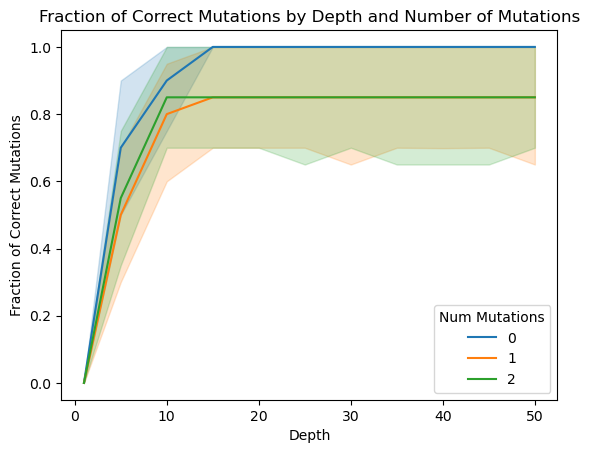

In [38]:
#SHow row with Na

# Convert 'Num Mutations' to a string if it's not already
df['Num Mutations'] = df['Num Mutations'].astype(str)

# Create a lineplot
sns.lineplot(data=df, x="Depth", y="Correct", hue="Num Mutations")

# Adding labels and title for clarity
plt.xlabel("Depth")
plt.ylabel("Fraction of Correct Mutations")
plt.title("Fraction of Correct Mutations by Depth and Number of Mutations")
plt.savefig("data/min_read_depth/depth_vs_correct_mutations_0to3.png", dpi=300)
# Show the plot
plt.show()

In [40]:
df[df["Num Mutations"] == "2"].head(20)

,Original Variant,Predicted Variant,Depth,Num Mutations,Correct,Alignment Frequency
440,"[T277C, C364T]",T41DEL_C54DEL_A55DEL_G67C_G69T_G109C_T121DEL_G...,1,2,0,1.0
441,"[T277C, C364T]",T277C_C364T,5,2,1,0.6
442,"[T277C, C364T]",T277C_C364T,10,2,1,0.7
443,"[T277C, C364T]",T277C_C364T,15,2,1,0.6
444,"[T277C, C364T]",T277C_C364T,20,2,1,0.4
445,"[T277C, C364T]",T277C_C364T,25,2,1,0.64
446,"[T277C, C364T]",T277C_C364T,30,2,1,0.566667
447,"[T277C, C364T]",T277C_C364T,35,2,1,0.571429
448,"[T277C, C364T]",T277C_C364T,40,2,1,0.6
449,"[T277C, C364T]",T277C_C364T,45,2,1,0.6


In [ ]:
bam_file = "/home/emre/github_repo/MinION/examples/data/min_read_depth/seq/A393G/depth_50/alignment.bam"
variant_pred = analyser.call_variant_pop_frequency(bam_file, template, reference, min_freq=0.1, min_depth= 1)

In [ ]:
variant_pred

In [ ]:
alignment_count = int(subprocess.run(f"samtools view -c {bam_file}", shell=True, capture_output=True).stdout.decode("utf-8").strip())
freq_dist = pd.DataFrame(analyser.get_highest_non_ref_base_freq_2(bam_file, reference, range(1,len(template)), template, qualities=False)[0]).T.rename(columns={0:"Base", 1:"Frequency"})

nb_positions = analyser.get_nb_positions(freq_dist, 0.4)

In [ ]:
ref_base = template[nb_positions[0] - 1]
pos = nb_positions[0]
base = freq_dist["Base"][nb_positions[0]]

In [345]:
df.tail(20)

,Original Variant,Predicted Variant,Depth,Num Mutations,Correct
420,[A393G],A393G,10,1,1
421,[A393G],A393G,15,1,1
422,[A393G],A393G,20,1,1
423,[A393G],A393G,25,1,1
424,[A393G],A393G,30,1,1
425,[A393G],A393G,35,1,1
426,[A393G],A393G,40,1,1
427,[A393G],A393G,45,1,1
428,[A393G],A393G,50,1,1
429,[T213A],C15DEL_G40DEL_G73DEL_C75DEL_A106C_T118DEL_T164...,1,1,0


In [ ]:
freq_dist.iloc[0]

In [ ]:
analyser.get_pop_frequency(bam_file, template, reference, nb_positions, min_freq=0.1, min_depth= 0)

In [ ]:
pd.DataFrame(variant_pred).sort_values("Alignment Frequency", ascending=False).reset_index(drop=True)

In [ ]:
variant_pred["Variant"][0]